In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset,Subset
import math
from sklearn.model_selection import train_test_split
import numpy as np 
import sys
import os
import pandas as pd
from torch.utils.data import random_split
import copy
import random

sys.path.append(os.path.abspath("../.."))

from config.model_config import ModelConfig
from config.experiment_config import ExperimentConfig, AvailableDatasets
from vol_predict.features.preprocessor import OneToOnePreprocessor
from torch.utils.data import Dataset

from vol_predict.models.dl.mlp_predictor import MLPPredictor as Model
from vol_predict.models.baselines.naive_predictor import NaivePredictor as Baseline
from vol_predict.loss.tm_loss import MixtureNormalNLL, MixtureLogNormalNLL, MixtureWeibullNLL, HingeNormalMixtureNLL, MixtureInverseGaussianNLL
from vol_predict.models.mixture.tm_pred2 import AbstractMixturePredictor, TM_N_Predictor,TM_LN_Predictor,TM_IG_Predictor,TM_W_Predictor
from vol_predict.loss.abstract_custom_loss import AbstractCustomLoss

from vol_predict.models.baselines.naive_predictor import NaivePredictor as Baseline
from run import initialize_runner, run_backtest
from vol_predict.loss.loss import Loss

from run import initialize_runner, run_backtest

In [10]:
data = pd.read_csv("../../data/spx/btc-2/data_df.csv")


In [11]:
data.dropna(inplace=True)
cols_to_drop = [col for col in data.columns if col.startswith("ask_depth_t")]
data.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = [col for col in data.columns if col.startswith("ret")]
data.drop(columns=cols_to_drop, inplace=True)

vol_mean = data["vol"].mean()
vol_std  = data["vol"].std()

for column in data.columns[2:]:
    mean = data[column].mean()
    sd = data[column].std()
    data[column] = (data[column]-mean)/sd

data["vol"] = (data["vol"])/data["vol"].std()
    

In [12]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # might slow down but ensures reproducibility
    torch.backends.cudnn.benchmark = False

In [13]:
def train_tm_n_model(
    train_loader,
    val_loader,
    ar_order,
    n,
    lb,
    model_type="normal",  # Options: normal, hinge, lognormal, inverse_gaussian, weibull
    learning_rate=1e-3,
    num_epochs=50,
    penalty_coef=1.0,
    delta=0.0,
    l2_coef=0.0,
    eps=1e-12,
    device="cpu"
):
    """
    Trains a specified temporal mixture model.

    Args:
        model_type: one of "normal", "hinge", "lognormal", "inverse_gaussian", "weibull"
    """
    set_seed(213769420)
    # --- Model Selection ---
    if model_type == "normal":
        model = TM_N_Predictor(ar_order, n, lb)
        loss_fn = MixtureNormalNLL(eps=eps, l2_coef=l2_coef)

    elif model_type == "hinge":
        model = TM_N_Predictor(ar_order, n, lb)
        loss_fn = HingeNormalMixtureNLL(
            penalty_coef=penalty_coef,
            delta=delta,
            eps=eps,
            l2_coef=l2_coef
        )

    elif model_type == "lognormal":
        model = TM_LN_Predictor(ar_order, n, lb)
        loss_fn = MixtureLogNormalNLL(eps=eps, l2_coef=l2_coef)

    elif model_type == "inverse_gaussian":
        model = TM_IG_Predictor(ar_order, n, lb)
        loss_fn = MixtureInverseGaussianNLL(eps=eps, l2_coef=l2_coef)

    elif model_type == "weibull":
        model = TM_W_Predictor(ar_order, n, lb)
        loss_fn = MixtureWeibullNLL(eps=eps, l2_coef=l2_coef)

    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    model = model.to(device)
    loss_fn.set_model(model) if hasattr(loss_fn, "set_model") else None
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    best_val_loss = float("inf")
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for vol_history, feats, target_vol in train_loader:
            vol_history = vol_history.to(device)
            feats = feats.to(device)
            target_vol = target_vol.to(device)

            if model.training:
                feats += 0.01 * torch.randn_like(feats)  # mały szum na wejściu


            optimizer.zero_grad()
            pred = model(vol_history, feats)
            loss = loss_fn(target_vol, pred, model)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item() * target_vol.size(0)

        train_loss = total_train_loss / len(train_loader.dataset)

        # --- Validation ---
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for vol_history, feats, target_vol in val_loader:
                vol_history = vol_history.to(device)
                feats = feats.to(device)
                target_vol = target_vol.to(device)

                pred = model(vol_history, feats)
                loss = loss_fn(target_vol, pred, model)
                total_val_loss += loss.item() * target_vol.size(0)

        val_loss = total_val_loss / len(val_loader.dataset)
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
        
        print(f"[Epoch {epoch+1:02d}/{num_epochs}] "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        # ───────────────────── DEBUG: podejrzyj parametry μ i σ ─────────────────────
        with torch.no_grad():
            # weź pierwszy batch z training loadera
            vol_hist, feats, _ = next(iter(train_loader))
            vol_hist = vol_hist.to(device)
            feats     = feats.to(device)

            out = model(vol_hist[:32], feats[:32])   # 32 przykłady na podgląd
            if model_type == "normal":
                print("\n===== DIAGNOSTYKA (pierwszych 5 próbek) =====")
                print("mean_logvol (AR)   :", out["ar_params"]["mean"][:5])
                print("mean_logvol (FEAT) :", out["feat_params"]["mean"][:5])
                print("sigma (AR)         :", out["ar_params"]["sigma"][:5])
                print("sigma (FEAT)       :", out["feat_params"]["sigma"][:5])
                print("mixture_mean       :", out["mixture_mean"][:5])
                print("gate weights       :", out["gate_weights"][:5])   # opcjonalnie
                print("================================================\n")

            elif model_type == "lognormal":
                print("\n===== DIAGNOSTYKA (pierwszych 5 próbek) =====")
                print("mean_logvol (AR)   :", out["ar_params"]["mean_logvol"][:5])
                print("mean_logvol (FEAT) :", out["feat_params"]["mean_logvol"][:5])
                print("sigma (AR)         :", out["ar_params"]["sigma"][:5])
                print("sigma (FEAT)       :", out["feat_params"]["sigma"][:5])
                print("mixture_mean       :", out["mixture_mean"][:5])
                print("gate weights       :", out["gate_weights"][:5])   # opcjonalnie
                print("================================================\n")
        

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model


In [14]:
class TMDataset(Dataset):
    def __init__(self, df, ar_order=16):
        """
        df:      pandas DataFrame
        ar_order: number of past vol entries to use
        """
        super().__init__()
        self.ar_order = ar_order

        # Extract the 'vol' column as a NumPy array
        self.vol_array = df["vol"].values  # shape [N]
        
        # Features: columns from index 2 onward
        self.feat_array = df.iloc[:, 2:].values  # shape [N, num_features]

        # We'll only create samples starting from row = ar_order
        # so that we have enough past volatility for an AR window
        self.valid_indices = range(ar_order, len(df))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        i = self.valid_indices[idx]

        # vol_history: the previous ar_order volatility values
        vol_history = self.vol_array[i - self.ar_order : i]  # shape = [ar_order]

        # features: row i's features
        features = self.feat_array[i, :]  # shape = [num_features]

        # target = volatility at row i
        target_vol = self.vol_array[i]

        # Convert everything to torch tensors
        vol_history = torch.tensor(vol_history, dtype=torch.float32)
        features = torch.tensor(features, dtype=torch.float32)
        target_vol = torch.tensor(target_vol, dtype=torch.float32)

        return vol_history, features, target_vol

In [15]:
def run_training(
    data: pd.DataFrame,
    model_type: str = "normal",
    ar_order: int = 32,
    lb: int = 120,  # 120 time steps for 1 hour of 30s features
    batch_size: int = 32,
    learning_rate: float = 1e-3,
    num_epochs: int = 30,
    penalty_coef: float = 1.0,
    delta: float = 0.0,
    l2_coef: float = 0.0,
    eps: float = 1e-12,
    device: str = "cpu",
    filter_outliers: bool = True,       # <--- nowa flaga
    outlier_std_threshold: float = 2.5  # <--- modyfikowalny próg
):
    set_seed(42)  # optional but recommended for reproducibility

    if model_type == "lognormal":
        data = data.copy()  # zapobiegamy modyfikacji oryginału

        vol_raw = data["vol"]  # zapamiętujemy oryginalną zmienność

        # log(volatile + ε), potem standaryzacja
        log_vol = np.log(data["vol"] + 1e-8)
        vol_mean = log_vol.mean()
        vol_std  = log_vol.std()
        data["vol"] = (log_vol - vol_mean) / vol_std

    dataset = TMDataset(data, ar_order=ar_order)
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_indices = list(range(0, train_size))
    val_indices = list(range(train_size, dataset_size))

    if filter_outliers:
        # --- wyciągnięcie targetów volatility z train setu ---
        vols = np.array([dataset[i][2].item() for i in train_indices])
        vol_mean = vols.mean()
        vol_std = vols.std()

        # --- filtracja ---
        keep_mask = (vols > vol_mean - outlier_std_threshold * vol_std) & \
                    (vols < vol_mean + outlier_std_threshold * vol_std)
        clean_train_indices = [i for keep, i in zip(keep_mask, train_indices) if keep]

        print(f"[INFO] Removed {len(train_indices) - len(clean_train_indices)} outliers from training set "
              f"({len(clean_train_indices)} kept out of {len(train_indices)})")

        train_dataset = torch.utils.data.Subset(dataset, clean_train_indices)
    else:
        train_dataset = torch.utils.data.Subset(dataset, train_indices)

    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # --- Calculate correct (n, lb) based on dataset shape ---
    num_features = data.shape[1] - 2  
    assert num_features % lb == 0, f"Expected total feature dim {num_features} to be divisible by lb={lb}"
    n = num_features // lb  # number of distinct features

    print(f"Training with n = {n}, lb = {lb} (total input dim = {n * lb})")

    model = train_tm_n_model(
        train_loader=train_loader,
        val_loader=val_loader,
        ar_order=ar_order,
        n=n,
        lb=lb,
        model_type=model_type,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        penalty_coef=penalty_coef,
        delta=delta,
        l2_coef=l2_coef,
        eps=eps,
        device=device
    )

    return model


[INFO] Removed 31 outliers from training set (2006 kept out of 2037)
Training with n = 18, lb = 60 (total input dim = 1080)
[Epoch 01/30] Train Loss: 105.357067 | Val Loss: 99.560301

===== DIAGNOSTYKA (pierwszych 5 próbek) =====
mean_logvol (AR)   : tensor([0.0699, 0.2248, 0.7432, 0.3249, 0.3159])
mean_logvol (FEAT) : tensor([-0.0046, -0.0045, -0.0045, -0.0044, -0.0046])
sigma (AR)         : tensor([1.0267, 0.9450, 0.7264, 0.9168, 0.8906])
sigma (FEAT)       : tensor([1.0024, 1.0023, 1.0024, 1.0023, 1.0024])
mixture_mean       : tensor([1.6886, 1.7504, 2.1936, 1.7376, 1.9420])
gate weights       : tensor([[0.2539, 0.7461],
        [0.3377, 0.6623],
        [0.5021, 0.4979],
        [0.2002, 0.7998],
        [0.7534, 0.2466]])

[Epoch 02/30] Train Loss: 103.777721 | Val Loss: 94.968567

===== DIAGNOSTYKA (pierwszych 5 próbek) =====
mean_logvol (AR)   : tensor([0.0733, 0.2297, 0.7477, 0.3304, 0.3212])
mean_logvol (FEAT) : tensor([-0.0091, -0.0091, -0.0090, -0.0090, -0.0092])
sigma (AR) 

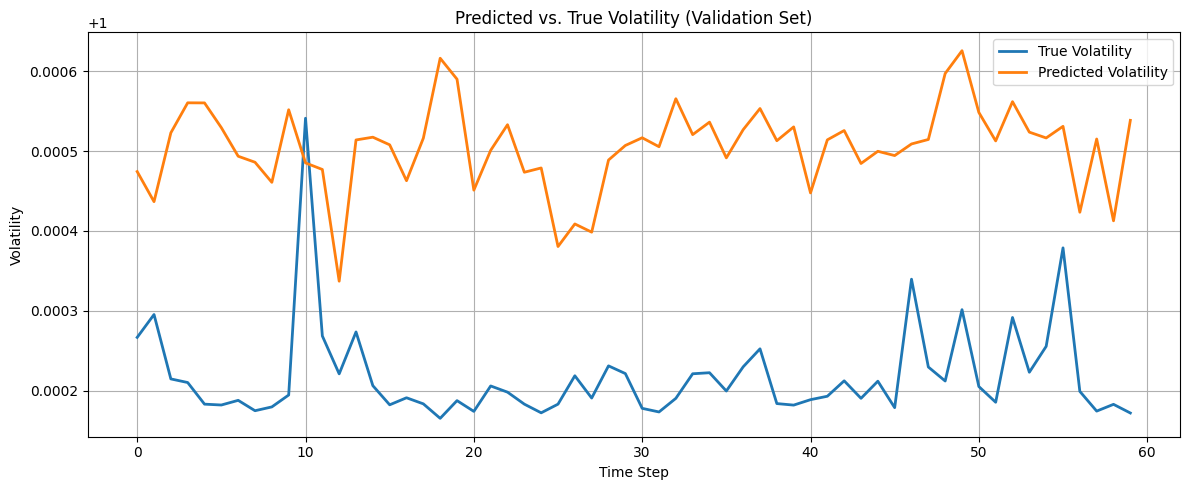

In [16]:
import matplotlib.pyplot as plt
ar_order = 32
batch_size = 32
lr = 0.0001
num_epochs = 30
penalty_coef = 1
delta = 0
l2_coef = 0.001
model_type = "lognormal"
model = run_training(
    data  = data,
    model_type = model_type,
    ar_order = ar_order,
    lb = 60,  # 120 time steps for 1 hour of 30s features
    batch_size = batch_size,
    learning_rate = lr,
    num_epochs = num_epochs,
    penalty_coef = penalty_coef,
    delta = delta,
    l2_coef =l2_coef ,
    eps = 1e-12,
    device = "cpu"
)
dataset = TMDataset(data, ar_order=ar_order)

# Chronological split: 80% train, 20% validation
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Validation set = last 20%
val_dataset = Subset(dataset, range(train_size, dataset_size))


# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model.eval()

preds = []
targets = []

with torch.no_grad():
    for vol_history, features, target_vol in val_loader:
        vol_history = vol_history.to("cpu")   # or "cuda" if model is on GPU
        features = features.to("cpu")
        target_vol = target_vol.to("cpu")

        output = model(vol_history, features)
        pred_vol = output["mixture_mean"]
        preds.extend(pred_vol.numpy())
        targets.extend(target_vol.numpy())

# Plot predicted vs. true
if model_type == "lognormal":
    preds_z = np.array(preds)
    targets_z = np.array(targets)
    # --- KROK 2: denormalizacja i exp() ---
    preds_lin    = np.exp(preds_z * vol_std + vol_mean) - 1e-8
    targets_lin  = np.exp(targets_z * vol_std + vol_mean) - 1e-8

    # --- Wykres w skali liniowej ---
    plt.figure(figsize=(12, 5))
    plt.plot(targets_lin[:60], label="True Volatility", linewidth=2)
    plt.plot(preds_lin[:60], label="Predicted Volatility", linewidth=2)
    plt.xlabel("Time Step")
    plt.ylabel("Volatility")
    plt.title("Predicted vs. True Volatility (Validation Set)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(12, 5))
    preds_raw    = np.array(preds)   * vol_std + vol_mean
    targets_raw  = np.array(targets) * vol_std + vol_mean

    plt.plot(targets[:60],  label="True Volatility")
    plt.plot(preds[:60],    label="Predicted Volatility")
    plt.xlabel("Time Step")
    plt.ylabel("Volatility")
    plt.title("Predicted vs. True Volatility (Validation Set)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()